In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!pip install transformers bitsandbytes sentencepiece accelerate guidance --upgrade -qq

In [3]:
!pip install --upgrade transformers -qq
!pip install accelerate
!pip install -q -U google-generativeai
!pip install --upgrade transformers -qq
!pip install accelerate
!pip install groq
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.2 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 919.2 kB/s eta 0:00:00--:--


In [4]:
!wget -nc https://people.eecs.berkeley.edu/~hendrycks/data.tar

--2024-06-28 09:30:57--  https://people.eecs.berkeley.edu/~hendrycks/data.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166184960 (158M) [application/x-tar]
Saving to: 'data.tar'

data.tar            100%[===================>] 158.49M  53.5MB/s    in 3.0s    

2024-06-28 09:31:01 (53.5 MB/s) - 'data.tar' saved [166184960/166184960]



In [5]:
# import tarfile
# unzip_path = '.'
# tar = tarfile.open('data.tar')
# tar.extractall(path=unzip_path)
# tar.close()

In [6]:
import pandas as pd
df_reasoning = pd.read_parquet("hf://datasets/livebench/reasoning/data/test-00000-of-00001.parquet")
df_math = pd.read_parquet("hf://datasets/livebench/math/data/test-00000-of-00001.parquet")
df_coding = pd.read_parquet("hf://datasets/livebench/coding/data/test-00000-of-00001.parquet")
df_language = pd.read_parquet("hf://datasets/livebench/language/data/test-00000-of-00001.parquet")
df_data_analysis = pd.read_parquet("hf://datasets/livebench/data_analysis/data/test-00000-of-00001.parquet")
# df_instruction = pd.read_parquet("hf://datasets/livebench/instruction_following/data/test-00000-of-00001.parquet")

In [7]:
df_reasoning.to_csv('reasoning_dev.csv', index=False)
df_math.to_csv('math_dev.csv', index=False)
df_language.to_csv('language_dev.csv', index=False)
df_data_analysis.to_csv('data_analysis_dev.csv', index=False)
df_coding.to_csv('coding_dev.csv', index=False)

In [8]:
print(df_reasoning.shape)
print(df_math.shape)
print(df_coding.shape)
print(df_language.shape)
print(df_data_analysis.shape)

(100, 5)
(232, 9)
(88, 13)
(140, 10)
(150, 5)


In [9]:
import os

dev_folder_path = '/kaggle/working/dev'
os.makedirs(dev_folder_path, exist_ok=True)

In [10]:
import os
import shutil

source_folder = '/kaggle/working/'
destination_folder = '/kaggle/working/dev'

files = os.listdir(source_folder)
csv_files = [file for file in files if file.endswith('.csv')]

for file in csv_files:
    source_file_path = os.path.join(source_folder, file)
    destination_file_path = os.path.join(destination_folder, file)
    shutil.move(source_file_path, destination_file_path)
    print(f"Moved '{file}' to '{destination_folder}'")

Moved 'data_analysis_dev.csv' to '/kaggle/working/dev'
Moved 'language_dev.csv' to '/kaggle/working/dev'
Moved 'coding_dev.csv' to '/kaggle/working/dev'
Moved 'math_dev.csv' to '/kaggle/working/dev'
Moved 'reasoning_dev.csv' to '/kaggle/working/dev'


In [11]:
import torch
import numpy as np
from sklearn.isotonic import IsotonicRegression
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline
from transformers import BitsAndBytesConfig
import torch.nn.functional as F
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
import google.generativeai as genai
from bert_score import score
import os
from groq import Groq
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import json
import re
import concurrent.futures
from tqdm import tqdm
from yaml import safe_load
from nltk.metrics import edit_distance

2024-06-28 09:31:18.954207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 09:31:18.954328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 09:31:19.068744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
import google.generativeai as genai
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


os.environ['GOOGLE_API_KEY']=""
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

In [15]:
client = Groq(api_key="")

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What is the meaning of life? How modern Ai is affeting the real life and what will be the Ai outcomes in future?",
        }

    ],
    model="llama3-70b-8192",
)
 
print(chat_completion.choices[0].message.content)

What a profound and timely set of questions!

**What is the meaning of life?**

The meaning of life is a question that has puzzled philosophers, theologians, scientists, and everyday people for centuries. There is no one definitive answer, as it is a subjective and personal query that can vary greatly from individual to individual. Here are a few perspectives:

1. **Biological perspective**: From a biological standpoint, the meaning of life might be to survive and reproduce, ensuring the continuation of our species.
2. **Philosophical perspective**: Philosophers have proposed various answers, such as:
	* **Hedonism**: The pursuit of pleasure and happiness is the primary goal of life.
	* **Eudaimonia**: Living a virtuous, fulfilling life, cultivating one's strengths and talents, is the key to a meaningful existence.
	* **Existentialism**: Life has no inherent meaning, and we must create our own purpose and significance.
3. **Religious perspective**: Religious beliefs often provide a fra

In [16]:
gemini_model = genai.GenerativeModel('gemini-pro')

### Pipeline

In [ ]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model, regex_pattern, temperature=0.8, max_tokens=300, pairwise=True):
        self.api_key = api_key
        self.judge_model = judge_model
        self.regex_pattern = re.compile(regex_pattern)
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.pairwise = pairwise
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

    def get_mistral_answer(self, prompt, include_stopwords=True):
        inputs = tokenizer_mistral.encode_plus(
            prompt, return_tensors='pt', max_length=1024, truncation=True, padding='max_length'
        ).to(mistral_model.device)

        outputs = mistral_model.generate(
            inputs['input_ids'], attention_mask=inputs['attention_mask'],
            max_new_tokens=300, num_return_sequences=1, temperature=0.8,
            do_sample=True, output_scores=True, return_dict_in_generate=True
        )

        response_ids = outputs.sequences[0]
        response_text = tokenizer_mistral.decode(response_ids, skip_special_tokens=True)

        logits = outputs.scores  # Logits of the generated tokens
        softmax_probs = torch.softmax(torch.stack(logits), dim=-1)

        tokens = tokenizer_mistral.convert_ids_to_tokens(response_ids)
        if include_stopwords:
            token_confidences = [prob.max().item() for prob in softmax_probs]
        else:
            token_confidences = [prob.max().item() for prob, token in zip(softmax_probs, tokens) if token.lower() not in stop_words]

        mean_confidence = np.mean(token_confidences)

        return response_text, mean_confidence

    def judge_answer(self, response, prompt):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
                }
            ],
            model="llama3-70b-8192",
        )

        llama3_response = chat_completion.choices[0].message.content.strip()
        return llama3_response

    def parse_evaluation(self, evaluation):
        if "1 point" in evaluation:
            return 1
        return 0

    def generate_reference_text(self, prompt):
        inputs = tokenizer_mistral.encode_plus(
            prompt, return_tensors='pt', max_length=1024, truncation=True, padding='max_length'
        ).to(mistral_model.device)

        outputs = mistral_model.generate(
            inputs['input_ids'], attention_mask=inputs['attention_mask'],
            max_new_tokens=300, num_return_sequences=1, temperature=0.8, do_sample=True
        )

        reference_text = tokenizer_mistral.decode(outputs[0], skip_special_tokens=True)
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate(self, prompts):
        self.prompts = prompts  # Ensure prompts are stored
        for prompt in prompts:
            response, confidence = self.get_mistral_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

    def plot_reliability_diagram(self, bins, bin_accuracies):
        plt.figure(figsize=(10, 6))
        plt.plot((bins[:-1] + bins[1:]) / 2, bin_accuracies, marker='o', label='Accuracy per bin')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model="llama3-70b-8192", regex_pattern=r"(correct|incorrect)")
prompts = ["What is nuclear fusion?", "Tell me about the current AI situation in the world?", "How does a combustion engine work?"]
pipeline.evaluate(prompts)

In [ ]:
data, bins, bin_accuracies = pipeline.calculate_ece()

In [ ]:
few_shot_examples = """
Q: What is nuclear fusion?
A: Nuclear fusion is a reaction in which two atomic nuclei combine to form a heavier nucleus, releasing energy in the process.

Q: How does a combustion engine work?
A: A combustion engine works by burning fuel in a combustion chamber to produce mechanical energy that drives the engine.
"""

def get_mistral_answer_few_shot(prompt):
    few_shot_prompt = few_shot_examples + f"\nQ: {prompt}\nA:"
    response, confidence = get_mistral_answer(few_shot_prompt)
    return response, confidence

# Example usage:
few_shot_response, few_shot_confidence = get_mistral_answer_few_shot("Tell me about the current AI situation in the world.")
print(f"Few-shot response: {few_shot_response}")
print(f"Few-shot confidence: {few_shot_confidence}")

### Class pipeline for mmlu dataset

In [14]:
class Tokenizer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text, max_length=1024):
        return self.tokenizer.encode_plus(text, return_tensors='pt', max_length=max_length, truncation=True)

    def decode(self, tokens):
        return self.tokenizer.decode(tokens, skip_special_tokens=True)

In [15]:
  class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens


        self.tokenizer = Tokenizer(smaller_model_name)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0])

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
                }
            ],
            model=self.judge_model_name,
        )

        judge_response = chat_completion.choices[0].message.content.strip()
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            max_new_tokens=self.max_tokens, 
            num_return_sequences=1, 
            temperature=self.temperature, 
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0])
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"
                
                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break

                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate_from_csv(filepath)

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [16]:
# pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2")
# pipeline.evaluate_folder("/kaggle/working/data/dev")

## Chain of thought

In [17]:
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
import torch.nn.functional as F
from bert_score import score

class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

    def generate_cot_prompt(self, question):
        # Chain of Thought prompt
        cot_prompt = f"Q: {question}\nA: Let's think through this step by step.\n"
        cot_prompt += "First, consider the main aspects of the question. "
        cot_prompt += "Next, break down the problem into smaller parts. "
        cot_prompt += "Finally, synthesize the information to form a coherent answer."
        return cot_prompt

    def get_model_answer(self, question):
        """Generates an answer from the specified model using Chain of Thought prompting."""
        prompt = self.generate_cot_prompt(question)
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
                }
            ],
            model=self.judge_model_name,
        )

        judge_response = chat_completion.choices[0].message.content.strip()
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'], 
            attention_mask=inputs['attention_mask'],
            max_new_tokens=self.max_tokens, 
            num_return_sequences=1, 
            temperature=self.temperature, 
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"
                
                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break

                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate_from_csv(filepath)

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)

    def calculate_ece(self):
        # Ensure all lists have the same length
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [18]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2")
pipeline.evaluate_folder("/kaggle/working/data/dev")

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Evaluating prehistory in category history...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BERTScore - Precision: 0.6339928507804871, Recall: 0.646126389503479, F1: 0.6392560601234436
Expected Calibration Error (ECE): 0.44999999999999996
prehistory ECE: 0.44999999999999996
Evaluating elementary_mathematics in category math...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6837377548217773, Recall: 0.7477951049804688, F1: 0.713681161403656
Expected Calibration Error (ECE): 0.050000000000000044
elementary_mathematics ECE: 0.050000000000000044
Evaluating college_physics in category physics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7158308625221252, Recall: 0.7305806279182434, F1: 0.7228883504867554
Expected Calibration Error (ECE): 0.44999999999999996
college_physics ECE: 0.44999999999999996
Evaluating professional_psychology in category psychology...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.659892201423645, Recall: 0.6891579627990723, F1: 0.6739794015884399
Expected Calibration Error (ECE): 0.050000000000000044
professional_psychology ECE: 0.050000000000000044
Evaluating professional_accounting in category other...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6989593505859375, Recall: 0.7309845685958862, F1: 0.7142873406410217
Expected Calibration Error (ECE): 0.5
professional_accounting ECE: 0.5
Evaluating college_computer_science in category computer science...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7804489731788635, Recall: 0.8155450224876404, F1: 0.797234296798706
Expected Calibration Error (ECE): 0.19999999999999996
college_computer_science ECE: 0.19999999999999996
Evaluating professional_medicine in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7515987157821655, Recall: 0.7363089323043823, F1: 0.7437739968299866
Expected Calibration Error (ECE): 0.050000000000000044
professional_medicine ECE: 0.050000000000000044
Evaluating moral_scenarios in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7018132209777832, Recall: 0.8154664039611816, F1: 0.7543392181396484
Expected Calibration Error (ECE): 0.19999999999999996
moral_scenarios ECE: 0.19999999999999996
Evaluating high_school_mathematics in category math...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.714411735534668, Recall: 0.7361297011375427, F1: 0.7244102358818054
Expected Calibration Error (ECE): 0.7
high_school_mathematics ECE: 0.7
Evaluating clinical_knowledge in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6294011473655701, Recall: 0.6284540295600891, F1: 0.6286017894744873
Expected Calibration Error (ECE): 0.19999999999999996
clinical_knowledge ECE: 0.19999999999999996
Evaluating marketing in category business...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6170973181724548, Recall: 0.6716013550758362, F1: 0.6417735815048218
Expected Calibration Error (ECE): 0.050000000000000044
marketing ECE: 0.050000000000000044
Evaluating management in category business...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.5874842405319214, Recall: 0.6876441836357117, F1: 0.6325666904449463
Expected Calibration Error (ECE): 0.44999999999999996
management ECE: 0.44999999999999996
Evaluating high_school_chemistry in category chemistry...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6899381875991821, Recall: 0.7074669003486633, F1: 0.6985300779342651
Expected Calibration Error (ECE): 0.44999999999999996
high_school_chemistry ECE: 0.44999999999999996
Evaluating virology in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6208117008209229, Recall: 0.5941415429115295, F1: 0.606736421585083
Expected Calibration Error (ECE): 0.44999999999999996
virology ECE: 0.44999999999999996
Evaluating moral_disputes in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.5990657806396484, Recall: 0.6261063814163208, F1: 0.610586404800415
Expected Calibration Error (ECE): 0.050000000000000044
moral_disputes ECE: 0.050000000000000044
Evaluating us_foreign_policy in category politics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6590663194656372, Recall: 0.6653509140014648, F1: 0.6602483987808228
Expected Calibration Error (ECE): 0.050000000000000044
us_foreign_policy ECE: 0.050000000000000044
Evaluating college_medicine in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6443365812301636, Recall: 0.6429410576820374, F1: 0.6435619592666626
Expected Calibration Error (ECE): 0.19999999999999996
college_medicine ECE: 0.19999999999999996
Evaluating world_religions in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6396685838699341, Recall: 0.6598471403121948, F1: 0.6493556499481201
Expected Calibration Error (ECE): 0.07500000000000001
world_religions ECE: 0.07500000000000001
Evaluating public_relations in category politics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6100300550460815, Recall: 0.7041884660720825, F1: 0.6532495021820068
Expected Calibration Error (ECE): 0.19999999999999996
public_relations ECE: 0.19999999999999996
Evaluating college_biology in category biology...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6936075687408447, Recall: 0.6982257962226868, F1: 0.6947707533836365
Expected Calibration Error (ECE): 0.44999999999999996
college_biology ECE: 0.44999999999999996
Evaluating abstract_algebra in category math...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6769496202468872, Recall: 0.6974403858184814, F1: 0.6866719126701355
Expected Calibration Error (ECE): 0.25000000000000006
abstract_algebra ECE: 0.25000000000000006
Evaluating philosophy in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6627349853515625, Recall: 0.6728911995887756, F1: 0.6667096018791199
Expected Calibration Error (ECE): 0.19999999999999996
philosophy ECE: 0.19999999999999996
Evaluating security_studies in category politics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6657552719116211, Recall: 0.6864618062973022, F1: 0.67559814453125
Expected Calibration Error (ECE): 0.19999999999999996
security_studies ECE: 0.19999999999999996
Evaluating anatomy in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6795506477355957, Recall: 0.6944300532341003, F1: 0.685681939125061
Expected Calibration Error (ECE): 0.050000000000000044
anatomy ECE: 0.050000000000000044
Evaluating logical_fallacies in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6087924242019653, Recall: 0.623183012008667, F1: 0.6146827936172485
Expected Calibration Error (ECE): 0.24999999999999997
logical_fallacies ECE: 0.24999999999999997
Evaluating college_mathematics in category math...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7361247539520264, Recall: 0.7744659185409546, F1: 0.7534113526344299
Expected Calibration Error (ECE): 0.44999999999999996
college_mathematics ECE: 0.44999999999999996
Evaluating global_facts in category other...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6144339442253113, Recall: 0.6477363109588623, F1: 0.6284106373786926
Expected Calibration Error (ECE): 0.050000000000000044
global_facts ECE: 0.050000000000000044
Evaluating professional_law in category law...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7822022438049316, Recall: 0.8072214722633362, F1: 0.7944397330284119
Expected Calibration Error (ECE): 0.44999999999999996
professional_law ECE: 0.44999999999999996
Evaluating high_school_computer_science in category computer science...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.72240149974823, Recall: 0.7563115358352661, F1: 0.7377078533172607
Expected Calibration Error (ECE): 0.19999999999999996
high_school_computer_science ECE: 0.19999999999999996
Evaluating electrical_engineering in category engineering...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BERTScore - Precision: 0.704463005065918, Recall: 0.7110668420791626, F1: 0.7075126767158508
Expected Calibration Error (ECE): 0.44999999999999996
electrical_engineering ECE: 0.44999999999999996
Evaluating high_school_physics in category physics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6649301648139954, Recall: 0.7568923830986023, F1: 0.7069213390350342
Expected Calibration Error (ECE): 0.44999999999999996
high_school_physics ECE: 0.44999999999999996
Evaluating high_school_psychology in category psychology...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6651532053947449, Recall: 0.6891831755638123, F1: 0.676491379737854
Expected Calibration Error (ECE): 0.19999999999999996
high_school_psychology ECE: 0.19999999999999996
Evaluating international_law in category law...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6141598224639893, Recall: 0.6216412782669067, F1: 0.6169857978820801
Expected Calibration Error (ECE): 0.24999999999999997
international_law ECE: 0.24999999999999997
Evaluating astronomy in category physics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6521729826927185, Recall: 0.6891274452209473, F1: 0.6696947813034058
Expected Calibration Error (ECE): 0.29999999999999993
astronomy ECE: 0.29999999999999993
Evaluating high_school_statistics in category math...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7476105690002441, Recall: 0.7890998125076294, F1: 0.7674471139907837
Expected Calibration Error (ECE): 0.44999999999999996
high_school_statistics ECE: 0.44999999999999996
Evaluating econometrics in category economics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7505456209182739, Recall: 0.8024786710739136, F1: 0.7753179669380188
Expected Calibration Error (ECE): 0.7
econometrics ECE: 0.7
Evaluating high_school_biology in category biology...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


BERTScore - Precision: 0.6344455480575562, Recall: 0.7458221912384033, F1: 0.6854252219200134
Expected Calibration Error (ECE): 0.19999999999999996
high_school_biology ECE: 0.19999999999999996
Evaluating human_aging in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6449713706970215, Recall: 0.6910526156425476, F1: 0.6668069362640381
Expected Calibration Error (ECE): 0.24999999999999997
human_aging ECE: 0.24999999999999997
Evaluating medical_genetics in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6394978761672974, Recall: 0.657630205154419, F1: 0.6479019522666931
Expected Calibration Error (ECE): 0.050000000000000044
medical_genetics ECE: 0.050000000000000044
Evaluating high_school_world_history in category history...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7807133793830872, Recall: 0.8330931663513184, F1: 0.8058438897132874
Expected Calibration Error (ECE): 0.07500000000000001
high_school_world_history ECE: 0.07500000000000001
Evaluating nutrition in category health...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.5790227651596069, Recall: 0.6216880083084106, F1: 0.5979691743850708
Expected Calibration Error (ECE): 0.19999999999999996
nutrition ECE: 0.19999999999999996
Evaluating miscellaneous in category other...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6453812718391418, Recall: 0.7123745679855347, F1: 0.6771827340126038
Expected Calibration Error (ECE): 0.050000000000000044
miscellaneous ECE: 0.050000000000000044
Evaluating conceptual_physics in category physics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6365315914154053, Recall: 0.6427524089813232, F1: 0.639305830001831
Expected Calibration Error (ECE): 0.5
conceptual_physics ECE: 0.5
Evaluating high_school_geography in category geography...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6304186582565308, Recall: 0.6660398244857788, F1: 0.6458275318145752
Expected Calibration Error (ECE): 0.09999999999999998
high_school_geography ECE: 0.09999999999999998
Evaluating business_ethics in category business...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6732578277587891, Recall: 0.7688603401184082, F1: 0.7152594327926636
Expected Calibration Error (ECE): 0.19999999999999996
business_ethics ECE: 0.19999999999999996
Evaluating sociology in category culture...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.629059910774231, Recall: 0.6954232454299927, F1: 0.6600255370140076
Expected Calibration Error (ECE): 0.19999999999999996
sociology ECE: 0.19999999999999996
Evaluating jurisprudence in category law...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6437543630599976, Recall: 0.6834267973899841, F1: 0.6619002819061279
Expected Calibration Error (ECE): 0.050000000000000044
jurisprudence ECE: 0.050000000000000044
Evaluating formal_logic in category philosophy...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7114101052284241, Recall: 0.7435455918312073, F1: 0.7261021733283997
Expected Calibration Error (ECE): 0.19999999999999996
formal_logic ECE: 0.19999999999999996
Evaluating college_chemistry in category chemistry...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.7091479301452637, Recall: 0.72735196352005, F1: 0.7179147601127625
Expected Calibration Error (ECE): 0.44999999999999996
college_chemistry ECE: 0.44999999999999996
Evaluating high_school_us_history in category history...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.8610353469848633, Recall: 0.914620041847229, F1: 0.886654794216156
Expected Calibration Error (ECE): 0.050000000000000044
high_school_us_history ECE: 0.050000000000000044
Evaluating high_school_government_and_politics in category politics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6286543011665344, Recall: 0.6596214175224304, F1: 0.643152117729187
Expected Calibration Error (ECE): 0.050000000000000044
high_school_government_and_politics ECE: 0.050000000000000044
Evaluating high_school_macroeconomics in category economics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.655210018157959, Recall: 0.644071102142334, F1: 0.6490761041641235
Expected Calibration Error (ECE): 0.19999999999999996
high_school_macroeconomics ECE: 0.19999999999999996
Evaluating machine_learning in category computer science...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6514697670936584, Recall: 0.6659669280052185, F1: 0.6585547924041748
Expected Calibration Error (ECE): 0.44999999999999996
machine_learning ECE: 0.44999999999999996
Evaluating human_sexuality in category culture...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6180141568183899, Recall: 0.6692608594894409, F1: 0.6419561505317688
Expected Calibration Error (ECE): 0.050000000000000044
human_sexuality ECE: 0.050000000000000044
Evaluating high_school_microeconomics in category economics...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.6687872409820557, Recall: 0.6676023006439209, F1: 0.667985200881958
Expected Calibration Error (ECE): 0.050000000000000044
high_school_microeconomics ECE: 0.050000000000000044
Evaluating computer_security in category computer science...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes.

BERTScore - Precision: 0.6233068704605103, Recall: 0.6450125575065613, F1: 0.6291664838790894
Expected Calibration Error (ECE): 0.050000000000000044
computer_security ECE: 0.050000000000000044
Evaluating high_school_european_history in category history...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end

BERTScore - Precision: 0.911251962184906, Recall: 0.9311766028404236, F1: 0.9210892915725708
Expected Calibration Error (ECE): 0.050000000000000044
high_school_european_history ECE: 0.050000000000000044


## Few-shot prompting

In [37]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs.input_ids,
            max_new_tokens=300,  # Limit the number of generated tokens
            num_return_sequences=1,
            temperature=self.temperature,
            output_scores=True,
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs.input_ids.shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

#     def judge_answer(self, response, prompt):
#         chat_completion = client.chat.completions.create(
#             messages=[
#                 {
#                     "role": "user",
#                     "content": f"""
#                         Review the user’s question and the corresponding response using the binary scoring system described below.
#                         - 0 points: The response is incorrect or does not address the user’s question.
#                         - 1 point: The response is correct and addresses the user’s question.

#                         User: {prompt}
#                         Response: {response}
#                         """
#                 }
#             ],
#             model=self.judge_model_name,
#         )

#         judge_response = chat_completion.choices[0].message.content.strip()
#         return judge_response
    def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs.input_ids,
            max_new_tokens=self.max_tokens,
            num_return_sequences=1,
            temperature=self.temperature,
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path):
        # Clear data before processing each file
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)
        self.prompts = df.iloc[:, 0].tolist()  # Take only the first column (questions)

        for prompt in self.prompts:
            response, confidence = self.get_model_answer(prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)  # Save results to CSV
        return data, bins, bin_accuracies

    def calculate_ece(self, confidences, accuracies):
        # Ensure all lists have the same length
        if len(confidences) == len(accuracies):
            data = pd.DataFrame({
                'confidence': confidences,
                'rating': accuracies
            })
        else:
            raise ValueError("Confidence and accuracy arrays must be of the same length")

        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        # Drop bins with NaN values
        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        # Ensure lengths match
        bin_confidences = bin_confidences[:len(bin_accuracies)]

        # Compute ECE
        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

    def evaluate_folder(self, dev_folder_path, test_folder_path, few_shot_samples=5):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}

        for filename in os.listdir(dev_folder_path):
            if filename.endswith(".csv"):
                dev_filepath = os.path.join(dev_folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"

                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break

                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")

                    # 1. Load and process dev data
                    dev_df = pd.read_csv(dev_filepath)
                    dev_questions = dev_df.iloc[:, 0].tolist()  # Take only the first column (questions)
                    dev_answers = dev_df.iloc[:, 5].tolist()  # Take answers from column F

                    # 2. Prepare few-shot examples
                    few_shot_prompts = []
                    few_shot_responses = []
                    for i, question in enumerate(dev_questions):
                        correct_answer_column = ord(dev_answers[i]) - ord('A') + 1  # Convert A, B, C, D to 1, 2, 3, 4
                        few_shot_prompts.append(question)
                        #few_shot_responses.append(dev_df.iloc[i, correct_answer_column])
                        few_shot_responses.append(dev_df.iloc[i, correct_answer_column - 1]) 

                    # 3. Load and process test data
                    test_filepath = os.path.join(test_folder_path, f"{class_name}_test.csv")
                    test_df = pd.read_csv(test_filepath)
                    test_questions = test_df.iloc[:few_shot_samples, 0].tolist()  # Take first 5 questions

                    # 4. Generate responses using few-shot prompting
                    test_responses = []
                    test_confidences = []
                    test_references = []
                    for question in test_questions:
                        # Add few-shot examples to the prompt
                        few_shot_prompt = "\n".join(f"Q: {q}\nA: {a}" for q, a in zip(few_shot_prompts, few_shot_responses))
                        full_prompt = f"{few_shot_prompt}\n\nQ: {question}\nA:"

                        response, confidence = self.get_model_answer(full_prompt)
                        test_responses.append(response)
                        test_confidences.append(confidence)

                        reference_text = self.generate_reference_text(question)  # Generate reference text for BERTscore
                        test_references.append(reference_text)

                    # 5. Judge answers
                    test_accuracies = []
                    for response, question in zip(test_responses, test_questions):
                        judgement = self.judge_answer(response, question)
                        accuracy = self.parse_evaluation(judgement)
                        test_accuracies.append(accuracy)

                    # 6. Calculate BERTscore
                    precision, recall, f1 = self.calculate_bertscore(test_references, test_responses)
                    print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

                    # 7. Calculate ECE (with modified confidence list)
                    data, bins, bin_accuracies = self.calculate_ece(test_confidences, test_accuracies)

                    # Align shapes and calculate ECE (same as before)
                    bin_confidences = (bins[:-1] + bins[1:]) / 2
                    valid_bins = bin_accuracies.dropna().index
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]
                    bin_confidences = bin_confidences[valid_bins]

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category (same as before)
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)

In [38]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2")
pipeline.evaluate_folder("/kaggle/working/data/dev", "/kaggle/working/data/test")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Evaluating medical_genetics in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4944817125797272, Recall: 0.503717839717865, F1: 0.4985562264919281
Expected Calibration Error (ECE): 0.95
medical_genetics ECE: 0.95
Evaluating moral_disputes in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.48141852021217346, Recall: 0.5655442476272583, F1: 0.5194173455238342
Expected Calibration Error (ECE): 0.95
moral_disputes ECE: 0.95
Evaluating prehistory in category history...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.49757593870162964, Recall: 0.5852855443954468, F1: 0.5335210561752319
Expected Calibration Error (ECE): 0.95
prehistory ECE: 0.95
Evaluating world_religions in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4913352429866791, Recall: 0.541679322719574, F1: 0.51507967710495
Expected Calibration Error (ECE): 0.95
world_religions ECE: 0.95
Evaluating high_school_world_history in category history...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.50331050157547, Recall: 0.5268734693527222, F1: 0.5146795511245728
Expected Calibration Error (ECE): 0.89
high_school_world_history ECE: 0.89
Evaluating college_physics in category physics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5451294183731079, Recall: 0.6357333064079285, F1: 0.5857875943183899
Expected Calibration Error (ECE): 0.95
college_physics ECE: 0.95
Evaluating moral_scenarios in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.6966349482536316, Recall: 0.6665096282958984, F1: 0.6804066896438599
Expected Calibration Error (ECE): 0.95
moral_scenarios ECE: 0.95
Evaluating college_medicine in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4626578390598297, Recall: 0.5632781386375427, F1: 0.5070357918739319
Expected Calibration Error (ECE): 0.95
college_medicine ECE: 0.95
Evaluating miscellaneous in category other...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4444577097892761, Recall: 0.6097609400749207, F1: 0.5126628875732422
Expected Calibration Error (ECE): 0.95
miscellaneous ECE: 0.95
Evaluating econometrics in category economics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5155665278434753, Recall: 0.6561673879623413, F1: 0.5769470930099487
Expected Calibration Error (ECE): 0.95
econometrics ECE: 0.95
Evaluating professional_law in category law...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5226927995681763, Recall: 0.5385300517082214, F1: 0.5304356813430786
Expected Calibration Error (ECE): 0.89
professional_law ECE: 0.89
Evaluating high_school_european_history in category history...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5066421627998352, Recall: 0.5277098417282104, F1: 0.5160042643547058
Expected Calibration Error (ECE): 0.79
high_school_european_history ECE: 0.79
Evaluating professional_accounting in category other...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4762069284915924, Recall: 0.5505895018577576, F1: 0.5104140043258667
Expected Calibration Error (ECE): 0.95
professional_accounting ECE: 0.95
Evaluating philosophy in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5077736973762512, Recall: 0.5764285326004028, F1: 0.5397974252700806
Expected Calibration Error (ECE): 0.91
philosophy ECE: 0.91
Evaluating international_law in category law...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5145498514175415, Recall: 0.5799599885940552, F1: 0.5449473857879639
Expected Calibration Error (ECE): 0.95
international_law ECE: 0.95
Evaluating high_school_geography in category geography...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4937314987182617, Recall: 0.5587372183799744, F1: 0.5228578448295593
Expected Calibration Error (ECE): 0.95
high_school_geography ECE: 0.95
Evaluating high_school_microeconomics in category economics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5588499307632446, Recall: 0.6061918139457703, F1: 0.5795276761054993
Expected Calibration Error (ECE): 0.95
high_school_microeconomics ECE: 0.95
Evaluating high_school_mathematics in category math...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.6009005904197693, Recall: 0.6805089116096497, F1: 0.6377071142196655
Expected Calibration Error (ECE): 0.93
high_school_mathematics ECE: 0.93
Evaluating public_relations in category politics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4809657037258148, Recall: 0.5872547030448914, F1: 0.5243476629257202
Expected Calibration Error (ECE): 0.93
public_relations ECE: 0.93
Evaluating human_sexuality in category culture...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5050601959228516, Recall: 0.5609462857246399, F1: 0.5297505855560303
Expected Calibration Error (ECE): 0.95
human_sexuality ECE: 0.95
Evaluating high_school_chemistry in category chemistry...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5043583512306213, Recall: 0.6035383939743042, F1: 0.5486699342727661
Expected Calibration Error (ECE): 0.95
high_school_chemistry ECE: 0.95
Evaluating business_ethics in category business...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.6061611175537109, Recall: 0.6299975514411926, F1: 0.6168230772018433
Expected Calibration Error (ECE): 0.95
business_ethics ECE: 0.95
Evaluating college_computer_science in category computer science...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.49995216727256775, Recall: 0.5556989908218384, F1: 0.5261520743370056
Expected Calibration Error (ECE): 0.93
college_computer_science ECE: 0.93
Evaluating conceptual_physics in category physics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5217126607894897, Recall: 0.5526703596115112, F1: 0.5364641547203064
Expected Calibration Error (ECE): 0.93
conceptual_physics ECE: 0.93
Evaluating college_biology in category biology...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5015072226524353, Recall: 0.5892207026481628, F1: 0.5417830944061279
Expected Calibration Error (ECE): 0.93
college_biology ECE: 0.93
Evaluating us_foreign_policy in category politics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.48206695914268494, Recall: 0.5621670484542847, F1: 0.517454981803894
Expected Calibration Error (ECE): 0.95
us_foreign_policy ECE: 0.95
Evaluating computer_security in category computer science...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5671586394309998, Recall: 0.6609498262405396, F1: 0.6102505922317505
Expected Calibration Error (ECE): 0.95
computer_security ECE: 0.95
Evaluating high_school_psychology in category psychology...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.46853503584861755, Recall: 0.5505161881446838, F1: 0.5060871839523315
Expected Calibration Error (ECE): 0.93
high_school_psychology ECE: 0.93
Evaluating high_school_physics in category physics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5760728120803833, Recall: 0.6845258474349976, F1: 0.6252900958061218
Expected Calibration Error (ECE): 0.93
high_school_physics ECE: 0.93
Evaluating high_school_us_history in category history...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5049761533737183, Recall: 0.5238852500915527, F1: 0.5136850476264954
Expected Calibration Error (ECE): 0.93
high_school_us_history ECE: 0.93
Evaluating professional_psychology in category psychology...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4605686664581299, Recall: 0.5801280736923218, F1: 0.512342095375061
Expected Calibration Error (ECE): 0.93
professional_psychology ECE: 0.93
Evaluating professional_medicine in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5400986075401306, Recall: 0.5699726343154907, F1: 0.5545991659164429
Expected Calibration Error (ECE): 0.95
professional_medicine ECE: 0.95
Evaluating human_aging in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.4640234410762787, Recall: 0.49402618408203125, F1: 0.47794514894485474
Expected Calibration Error (ECE): 0.8700000000000001
human_aging ECE: 0.8700000000000001
Evaluating high_school_biology in category biology...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5039244294166565, Recall: 0.5957939624786377, F1: 0.5393799543380737
Expected Calibration Error (ECE): 0.95
high_school_biology ECE: 0.95
Evaluating management in category business...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5359740853309631, Recall: 0.5380391478538513, F1: 0.5364123582839966
Expected Calibration Error (ECE): 0.95
management ECE: 0.95
Evaluating high_school_statistics in category math...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5614379644393921, Recall: 0.6570199728012085, F1: 0.6052109003067017
Expected Calibration Error (ECE): 0.93
high_school_statistics ECE: 0.93
Evaluating clinical_knowledge in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.48507174849510193, Recall: 0.5623006224632263, F1: 0.5204794406890869
Expected Calibration Error (ECE): 0.95
clinical_knowledge ECE: 0.95
Evaluating sociology in category culture...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.48917046189308167, Recall: 0.5322325825691223, F1: 0.5096436738967896
Expected Calibration Error (ECE): 0.95
sociology ECE: 0.95
Evaluating high_school_computer_science in category computer science...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5417710542678833, Recall: 0.6961960792541504, F1: 0.6088815927505493
Expected Calibration Error (ECE): 0.91
high_school_computer_science ECE: 0.91
Evaluating elementary_mathematics in category math...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5284029245376587, Recall: 0.6746370196342468, F1: 0.5921458601951599
Expected Calibration Error (ECE): 0.95
elementary_mathematics ECE: 0.95
Evaluating abstract_algebra in category math...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.7013205289840698, Recall: 0.7085933685302734, F1: 0.703197181224823
Expected Calibration Error (ECE): 0.95
abstract_algebra ECE: 0.95
Evaluating college_chemistry in category chemistry...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.537734866142273, Recall: 0.6212443709373474, F1: 0.5760563015937805
Expected Calibration Error (ECE): 0.95
college_chemistry ECE: 0.95
Evaluating nutrition in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.48830166459083557, Recall: 0.5530050992965698, F1: 0.5183573961257935
Expected Calibration Error (ECE): 0.95
nutrition ECE: 0.95
Evaluating high_school_macroeconomics in category economics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5201281905174255, Recall: 0.5834554433822632, F1: 0.5493096113204956
Expected Calibration Error (ECE): 0.95
high_school_macroeconomics ECE: 0.95
Evaluating college_mathematics in category math...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5760151147842407, Recall: 0.6616584062576294, F1: 0.6158018112182617
Expected Calibration Error (ECE): 0.95
college_mathematics ECE: 0.95
Evaluating formal_logic in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.6188668012619019, Recall: 0.6917294859886169, F1: 0.651607096195221
Expected Calibration Error (ECE): 0.93
formal_logic ECE: 0.93
Evaluating high_school_government_and_politics in category politics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5047168731689453, Recall: 0.6098519563674927, F1: 0.550698459148407
Expected Calibration Error (ECE): 0.95
high_school_government_and_politics ECE: 0.95
Evaluating anatomy in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5157326459884644, Recall: 0.5697611570358276, F1: 0.539932370185852
Expected Calibration Error (ECE): 0.95
anatomy ECE: 0.95
Evaluating virology in category health...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.47709113359451294, Recall: 0.4937059283256531, F1: 0.48447805643081665
Expected Calibration Error (ECE): 0.95
virology ECE: 0.95
Evaluating marketing in category business...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.518837571144104, Recall: 0.6061579585075378, F1: 0.5586507320404053
Expected Calibration Error (ECE): 0.93
marketing ECE: 0.93
Evaluating electrical_engineering in category engineering...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5466245412826538, Recall: 0.609437882900238, F1: 0.5758200883865356
Expected Calibration Error (ECE): 0.95
electrical_engineering ECE: 0.95
Evaluating security_studies in category politics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5424862504005432, Recall: 0.6195226311683655, F1: 0.5783966779708862
Expected Calibration Error (ECE): 0.95
security_studies ECE: 0.95
Evaluating astronomy in category physics...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5155247449874878, Recall: 0.5444375276565552, F1: 0.5291396379470825
Expected Calibration Error (ECE): 0.95
astronomy ECE: 0.95
Evaluating jurisprudence in category law...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5407916307449341, Recall: 0.5943735241889954, F1: 0.5647557973861694
Expected Calibration Error (ECE): 0.95
jurisprudence ECE: 0.95
Evaluating global_facts in category other...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5242142081260681, Recall: 0.5461180806159973, F1: 0.5340294241905212
Expected Calibration Error (ECE): 0.95
global_facts ECE: 0.95
Evaluating logical_fallacies in category philosophy...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5520535707473755, Recall: 0.6328607797622681, F1: 0.5887747406959534
Expected Calibration Error (ECE): 0.95
logical_fallacies ECE: 0.95
Evaluating machine_learning in category computer science...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attentio

BERTScore - Precision: 0.5269377827644348, Recall: 0.658031165599823, F1: 0.5841397047042847
Expected Calibration Error (ECE): 0.95
machine_learning ECE: 0.95


## FROM mike

In [1]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300, ntrain=5):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.ntrain = ntrain

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

    def format_example(self, df, idx, include_answer=True):
        prompt = str(df.iloc[idx, 0])
        for j in range(1, df.shape[1] - 1):
            value = df.iloc[idx, j]
            if pd.isna(value):
                value = ""
            prompt += f"\n{chr(64+j)}. {str(value)}"
        prompt += "\nAnswer: "
        if include_answer:
            answer = df.iloc[idx, df.shape[1] - 1]
            if pd.isna(answer):
                answer = ""
            prompt += f"{str(answer)}\n\n"
        return prompt

    def gen_prompt(self, train_df, k=-1):
        prompt = "The following are multiple choice questions (with answers).\n\n"
        if k == -1:
            k = train_df.shape[0]
        for i in range(k):
            prompt += self.format_example(train_df, i)
        return prompt

    def get_model_answer(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'],
            max_new_tokens=300,
            num_return_sequences=1,
            temperature=self.temperature,
            output_scores=True,
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

#     def judge_answer(self, response, prompt):
#         chat_completion = client.chat.completions.create(
#             messages=[
#                 {
#                     "role": "user",
#                     "content": f"""
#                         Review the user’s question and the corresponding response using the binary scoring system described below.
#                         - 0 points: The response is incorrect or does not address the user’s question.
#                         - 1 point: The response is correct and addresses the user’s question.

#                         User: {prompt}
#                         Response: {response}
#                         """
#                 }
#             ],
#             model=self.judge_model_name,
#         )

#         judge_response = chat_completion.choices[0].message.content.strip()
#         return judge_response
    
    def judge_answer(self, response, prompt):
        evaluation_prompt =  f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
        judge_response = gemini_model.generate_content(evaluation_prompt)
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'],
            max_new_tokens=self.max_tokens,
            num_return_sequences=1,
            temperature=self.temperature,
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return reference_text

    def calculate_bertscore(self, references, candidates):
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate(self, dev_folder_path, test_folder_path, num_test_questions=5):
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        dev_dfs = []
        for filename in os.listdir(dev_folder_path):
            if filename.endswith(".csv"):
                dev_filepath = os.path.join(dev_folder_path, filename)
                dev_df = pd.read_csv(dev_filepath)
                dev_dfs.append(dev_df)

        dev_df = pd.concat(dev_dfs)

        test_prompts = []
        for filename in os.listdir(test_folder_path):
            if filename.endswith(".csv"):
                test_filepath = os.path.join(test_folder_path, filename)
                test_df = pd.read_csv(test_filepath)
                test_prompts.extend(test_df.iloc[:, 0].tolist())

        # Limit the number of test questions
        test_prompts = test_prompts[:num_test_questions]

        for prompt in test_prompts:
            few_shot_prompt = self.gen_prompt(dev_df, k=self.ntrain) + str(prompt) + "\nAnswer: "
            response, confidence = self.get_model_answer(few_shot_prompt)
            self.responses.append(response)
            self.confidences.append(confidence)
            reference_text = self.generate_reference_text(prompt)
            self.references.append(reference_text)
            judgement = self.judge_answer(response, prompt)
            accuracy = self.parse_evaluation(judgement)
            self.accuracies.append(accuracy)
            self.prompts.append(prompt)  # Ensure the prompt is also appended here

        if len(self.prompts) != len(self.responses) or len(self.prompts) != len(self.confidences) or len(self.prompts) != len(self.accuracies):
            raise ValueError("All arrays must be of the same length")

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path, num_test_questions=5):
        results = {}  # Store ECE values for each class
        category_results = {category: [] for category in set(cat for sublist in self.categories.values() for cat in sublist)}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8]  # Extract class name from filename without "_dev.csv"

                category_name = None
                for key, value in self.categories.items():
                    if key == class_name:
                        category_name = value[0]
                        break

                if category_name:
                    print(f"Evaluating {class_name} in category {category_name}...")
                    data, bins, bin_accuracies = self.evaluate(filepath, num_test_questions)

                    # Align shapes and calculate ECE
                    bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                    valid_bins = bin_accuracies.dropna().index  # Bins with data
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                    bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

        # Calculate average ECE for each category and save to CSV
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)

    def calculate_ece(self):
        data = pd.DataFrame({
            'prompt': self.prompts,
            'response': self.responses,
            'confidence': self.confidences,
            'rating': self.accuracies
        })

        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        bin_confidences = bin_confidences[:len(bin_accuracies)]

        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [36]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name="mistralai/Mistral-7B-Instruct-v0.2")
pipeline.evaluate(dev_folder_path="/kaggle/working/data/dev", test_folder_path="/kaggle/working/data/test", num_test_questions=5)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_

BERTScore - Precision: 0.3878081738948822, Recall: 0.4060923457145691, F1: 0.39653247594833374
Expected Calibration Error (ECE): 0.95


(                                              prompt  \
 0  Ms. Perez drove a total of 40 miles in 5 days....   
 1                   Find the quotient of −40 ÷ (−8).   
 2  A soccer team has $90.00 to buy soccer balls. ...   
 3  You and three friends go to a concert. The tot...   
 4  Use the expression below to answer the questio...   
 
                                             response  confidence  rating  \
 0  The following are multiple choice questions (w...    0.915953       0   
 1  The following are multiple choice questions (w...    0.835674       0   
 2  The following are multiple choice questions (w...    0.856325       0   
 3  The following are multiple choice questions (w...    0.862580       0   
 4  The following are multiple choice questions (w...    0.902784       0   
 
    confidence_normalized  bin  
 0               1.000000    9  
 1               0.912355    9  
 2               0.934901    9  
 3               0.941729    9  
 4               0.985623  

## NEW PIPELINE

## Zero shot prompting with livebench and mmlu

In [28]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.categories = {
            "data_analysis": ["data_analysis"],
            "coding": ["coding"],
            "language": ["language"],
            "reasoning": ["reasoning"],
            "math": ["math"],
        }

    def get_model_answer(self, prompt):
        """Generates an answer from the specified model."""
        inputs = self.tokenizer.encode(prompt).to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs['input_ids'],
            max_new_tokens=self.max_tokens,  # Limit the number of generated tokens
            num_return_sequences=1,
            temperature=self.temperature,
            output_scores=True,
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0])

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def evaluate_dataset(self, dataset_name, number_of_questions=None):
        """Evaluates the model on the specified dataset."""

        if dataset_name == "mmlu":
            # Your existing MMlu evaluation logic (unchanged from previous code)
            # ...
        elif dataset_name == "livebench":
            self.evaluate_livebench(number_of_questions)
        else:
            raise ValueError(f"Invalid dataset name: {dataset_name}. Valid options are 'mmlu' and 'livebench'.")

    def evaluate_livebench(self, number_of_questions=None):
        """Evaluates the model on the LiveBench dataset."""
        results = []  # List to store results for each category

        for category in self.categories.keys():
            file_path = f"livebench_data/{category}.csv"  # Replace with your actual file paths
            df = pd.read_csv(file_path)

            # Drop rows with missing ground truth values
            if category == "coding":
                df = df.dropna(subset=["solution"])
            else:
                df = df.dropna(subset=["ground_truth"])

            if number_of_questions is not None:
                df = df.sample(n=number_of_questions, random_state=42)  # Randomly sample questions

            prompts = df["turns"].tolist()
            ground_truths = df["ground_truth"].tolist() if category != "coding" else df["solution"].tolist()

            responses = []
            confidences = []

            for prompt in prompts:
                response, confidence = self.get_model_answer(prompt)
                responses.append(response)
                confidences.append(confidence)

            accuracies = [1 if response.strip() == ground_truth.strip() else 0 for response, ground_truth in zip(responses, ground_truths)]
            
            # Calculate ECE
            data = pd.DataFrame({
                "prompt": prompts,
                "response": responses,
                "confidence": confidences,
                "accuracy": accuracies
            })

            data, bins, bin_accuracies = self.calculate_ece(data)
            ece = np.sum(np.abs(bin_accuracies - (bins[:-1] + bins[1:]) / 2) * data['bin'].value_counts(normalize=True))
            print(f"Category: {category}, ECE: {ece}")

            results.append({
                "category": category,
                "ece": ece
            })

    # Save the results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv("livebench_results.csv", index=False) 

    # Return the results for each category
    return results 

    def calculate_ece(self, data):
        """Calculates the Expected Calibration Error (ECE)."""
        # Normalize confidence scores
        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        # Bin the normalized confidence scores
        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        # Calculate accuracy for each bin
        bin_accuracies = data.groupby('bin')['accuracy'].mean()

        return data, bins, bin_accuracies

## GPT

In [17]:
class Tokenizer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text, max_length=1024):
        return self.tokenizer.encode_plus(text, return_tensors='pt', max_length=max_length, truncation=True)

    def decode(self, tokens):
        return self.tokenizer.decode(tokens, skip_special_tokens=True)

In [18]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.smaller_model_name = smaller_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.mmlu_categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

        self.livebench_categories = {
            "data_analysis": ["data_analysis"],
            "coding": ["coding"],
            "language": ["language"],
            "reasoning": ["reasoning"],
            "math": ["math"],
        }

    def get_model_answer(self, prompt):
        inputs = self.tokenizer.encode(prompt, return_tensors="pt").to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs, 
            max_new_tokens=300,
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
        response = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs.shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
                }
            ],
            model=self.judge_model_name,
        )

        judge_response = chat_completion.choices[0].message.content.strip()
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt, return_tensors="pt").to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs,
            max_new_tokens=self.max_tokens,
            num_return_sequences=1,
            temperature=self.temperature,
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return reference_text


    def calculate_bertscore(self, references, candidates):
        references = list(references)
        candidates = list(candidates)
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path, dataset_type, num_questions=None):
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)

        if dataset_type == "mmlu":
            self.prompts = df.iloc[:, 0].tolist()
            if num_questions:
                self.prompts = self.prompts[:num_questions]
                
            for prompt in self.prompts:
                response, confidence = self.get_model_answer(prompt)
                self.responses.append(response)
                self.confidences.append(confidence)
                reference_text = self.generate_reference_text(prompt)
                self.references.append(reference_text)
                judgement = self.judge_answer(response, prompt)
                accuracy = self.parse_evaluation(judgement)
                self.accuracies.append(accuracy)
                
        elif dataset_type == "livebench":
            if "coding" in csv_file_path:
                self.prompts = df["turns"].tolist()
                self.references = df["solution"].tolist()
            else:
                self.prompts = df["turns"].tolist()
                self.references = df["ground_truth"].tolist()
            
            # Filter out rows where "turns" has a value but "ground_truth"/"solution" is empty
            self.prompts, self.references = zip(*[
                (prompt, reference) for prompt, reference in zip(self.prompts, self.references) 
                if pd.notna(prompt) and pd.notna(reference)
            ])

            if num_questions:
                self.prompts = self.prompts[:num_questions]
                self.references = self.references[:num_questions]

            for prompt, reference in zip(self.prompts, self.references):
                response, confidence = self.get_model_answer(prompt)
                self.responses.append(response)
                self.confidences.append(confidence)
                similarity = 1 - (edit_distance(response.strip(), reference.strip()) / 
                                max(len(response.strip()), len(reference.strip()))) 
                self.accuracies.append(similarity)
#                 accuracy = 1 if response.strip() == reference.strip() else 0
#                 self.accuracies.append(accuracy)

        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)
        
        # Save BERTScore along with ECE results
        data['precision'] = precision
        data['recall'] = recall
        data['f1'] = f1
        data.to_csv("results.csv", index=False)
        
        return data, bins, bin_accuracies

    def evaluate_folder(self, folder_path, dataset_type, num_questions=None):
        results = {}
        reliability_data = {}
        category_results = {category: [] for category in set(cat for sublist in self.mmlu_categories.values() for cat in sublist)}

        if dataset_type == "livebench":
            category_results = {category: [] for category in set(cat for sublist in self.livebench_categories.values() for cat in sublist)}

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8] 
                data, bins, bin_accuracies = self.evaluate_from_csv(filepath, dataset_type, num_questions)
                results[class_name] = data
        
                
                # Store class-wise data for reliability diagram
                reliability_data[class_name] = {
                    'bin_confidences': (bins[:-1] + bins[1:]) / 2,
                    'bin_accuracies': bin_accuracies
                }
                if dataset_type == "mmlu":
                    for category_name in self.mmlu_categories.get(class_name, []):
                        # Calculate ECE within the category loop
                        bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                        valid_bins = bin_accuracies.dropna().index  # Bins with data
                        bin_accuracies = bin_accuracies[valid_bins]
                        bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                        bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                        category_results[category_name].append(ece)
                        print(f"{class_name} ECE: {ece}")

                elif dataset_type == "livebench":
                    for category_name in self.livebench_categories.get(class_name, []):
                        # Calculate ECE within the category loop
                        bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
                        valid_bins = bin_accuracies.dropna().index  # Bins with data
                        bin_accuracies = bin_accuracies[valid_bins]
                        bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
                        bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

                        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                        category_results[category_name].append(ece)
                        print(f"{class_name} ECE: {ece}")
                        
                
                print(f"Processed {class_name}")

        # Calculate average ECE for each category
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}

        # Save average ECE results to 'category_results.csv'
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("category_results.csv", index=False)

        
        # Save BERTScore results for all classes
        bertscore_results = {
            class_name: {
                'precision': results[class_name]['precision'].iloc[0],
                'recall': results[class_name]['recall'].iloc[0],
                'f1': results[class_name]['f1'].iloc[0]
            }
            for class_name in results
        }
        bertscore_df = pd.DataFrame.from_dict(bertscore_results, orient='index')
        bertscore_df.to_csv("bertscore_results.csv", index=True)
        
        # Plot reliability diagram for all classes in one figure
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Find the maximum number of bins across all classes
        max_bins = max([len(data['bin_accuracies']) for data in reliability_data.values()])

        # Pad bin_accuracies with NaN to ensure equal lengths for plotting
        for class_name, data in reliability_data.items():
            num_missing_bins = max_bins - len(data['bin_accuracies'])
            data['bin_accuracies'] = np.pad(data['bin_accuracies'], (0, num_missing_bins), 'constant', constant_values=np.nan)

            plt.scatter(data['bin_confidences'][:max_bins], data['bin_accuracies'], label=class_name, s=50)

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram for All Classes')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_ece(self):
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        bin_confidences = bin_confidences[:len(bin_accuracies)]

        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [19]:
## All Models
models = [
    {'name': 'Qwen/Qwen2-7B-Instruct'},
    {'name': 'stabilityai/StableBeluga-7B'},
    {'name': 'meta-llama/Meta-Llama-3-8B'}, 
    {'name': 'teknium/OpenHermes-2.5-Mistral-7B'}, 
    {'name': 'mistralai/Mistral-7B-Instruct-v0.2'},  
    {'name': 'HuggingFaceH4/zephyr-7b-beta'},
]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore - Precision: 0.17247484624385834, Recall: 0.5036329627037048, F1: 0.25607556104660034
Expected Calibration Error (ECE): 0.8827504120944698
reasoning ECE: 0.8827504120944698
Processed reasoning
BERTScore - Precision: 0.3940548002719879, Recall: 0.5945001244544983, F1: 0.4717040956020355
Expected Calibration Error (ECE): 0.8229033381304475
data_analysis ECE: 0.8229033381304475
Processed data_analysis
BERTScore - Precision: 0.48737087845802307, Recall: 0.5981023907661438, F1: 0.5363543629646301
Expected Calibration Error (ECE): 0.6784741213273181
coding ECE: 0.6784741213273181
Processed coding
BERTScore - Precision: 0.5192601680755615, Recall: 0.7268938422203064, F1: 0.6028556823730469
Expected Calibration Error (ECE): 0.7120019634017969
math ECE: 0.7120019634017969
Processed math
BERTScore - Precision: 0.6835563778877258, Recall: 0.8247531056404114, F1: 0.7467145323753357
Expected Calibration Error (ECE): 0.4386239308816119
language ECE: 0.4386239308816119
Processed language


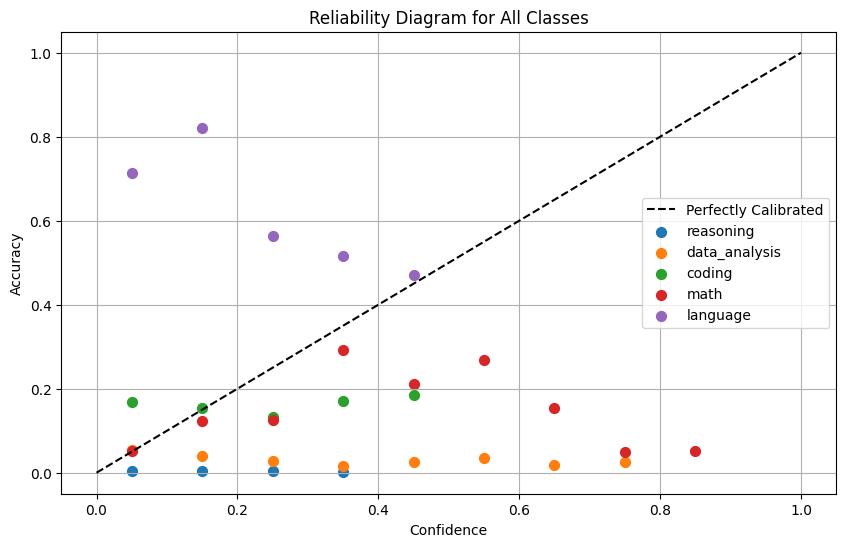

In [20]:
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name=models[0]['name'])
pipeline.evaluate_folder("/kaggle/working/dev", dataset_type="livebench", num_questions=50) # if u control question
# pipeline.evaluate_folder("/kaggle/working/dev", dataset_type="livebench")

## Chain of thoughts

In [17]:
class Tokenizer:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text, max_length=1024):
        return self.tokenizer.encode_plus(text, return_tensors='pt', max_length=max_length, truncation=True)

    def decode(self, tokens):
        return self.tokenizer.decode(tokens, skip_special_tokens=True)

In [18]:
class EvaluationPipeline:
    def __init__(self, api_key, judge_model_name, smaller_model_name, temperature=0.8, max_tokens=300):
        self.api_key = api_key
        self.judge_model_name = judge_model_name
        self.smaller_model_name = smaller_model_name
        self.temperature = temperature
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(smaller_model_name)

        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

        self.main_model = AutoModelForCausalLM.from_pretrained(
            smaller_model_name,
            torch_dtype=torch.float16,
            quantization_config=bnb_config,
            low_cpu_mem_usage=True,
            device_map="auto",
        )

        self.mmlu_categories = {
            "abstract_algebra": ["math"],
            "anatomy": ["health"],
            "astronomy": ["physics"],
            "business_ethics": ["business"],
            "clinical_knowledge": ["health"],
            "college_biology": ["biology"],
            "college_chemistry": ["chemistry"],
            "college_computer_science": ["computer science"],
            "college_mathematics": ["math"],
            "college_medicine": ["health"],
            "college_physics": ["physics"],
            "computer_security": ["computer science"],
            "conceptual_physics": ["physics"],
            "econometrics": ["economics"],
            "electrical_engineering": ["engineering"],
            "elementary_mathematics": ["math"],
            "formal_logic": ["philosophy"],
            "global_facts": ["other"],
            "high_school_biology": ["biology"],
            "high_school_chemistry": ["chemistry"],
            "high_school_computer_science": ["computer science"],
            "high_school_european_history": ["history"],
            "high_school_geography": ["geography"],
            "high_school_government_and_politics": ["politics"],
            "high_school_macroeconomics": ["economics"],
            "high_school_mathematics": ["math"],
            "high_school_microeconomics": ["economics"],
            "high_school_physics": ["physics"],
            "high_school_psychology": ["psychology"],
            "high_school_statistics": ["math"],
            "high_school_us_history": ["history"],
            "high_school_world_history": ["history"],
            "human_aging": ["health"],
            "human_sexuality": ["culture"],
            "international_law": ["law"],
            "jurisprudence": ["law"],
            "logical_fallacies": ["philosophy"],
            "machine_learning": ["computer science"],
            "management": ["business"],
            "marketing": ["business"],
            "medical_genetics": ["health"],
            "miscellaneous": ["other"],
            "moral_disputes": ["philosophy"],
            "moral_scenarios": ["philosophy"],
            "nutrition": ["health"],
            "philosophy": ["philosophy"],
            "prehistory": ["history"],
            "professional_accounting": ["other"],
            "professional_law": ["law"],
            "professional_medicine": ["health"],
            "professional_psychology": ["psychology"],
            "public_relations": ["politics"],
            "security_studies": ["politics"],
            "sociology": ["culture"],
            "us_foreign_policy": ["politics"],
            "virology": ["health"],
            "world_religions": ["philosophy"],
        }

        self.livebench_categories = {
            "data_analysis": ["data_analysis"],
            "coding": ["coding"],
            "language": ["language"],
            "reasoning": ["reasoning"],
            "math": ["math"],
        }

    def generate_cot_prompt(self, question):
        # Chain of Thought prompt
        cot_prompt = f"Q: {question}\nA: Let's think through this step by step.\n"
        cot_prompt += "First, consider the main aspects of the question. "
        cot_prompt += "Next, break down the problem into smaller parts. "
        cot_prompt += "Finally, synthesize the information to form a coherent answer."
        return cot_prompt

    def get_model_answer(self, question):
        """Generates an answer from the specified model using Chain of Thought prompting."""
        prompt = self.generate_cot_prompt(question)
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.main_model.device)
        attention_mask = inputs["attention_mask"] 

        outputs = self.main_model.generate(
            input_ids=inputs["input_ids"], 
            attention_mask=attention_mask, 
            max_new_tokens=300,
            num_return_sequences=1, 
            temperature=self.temperature, 
            output_scores=True, 
            return_dict_in_generate=True
        )
#         outputs = self.main_model.generate(
#             inputs['input_ids'], 
#             max_new_tokens=300,  # Limit the number of generated tokens
#             num_return_sequences=1, 
#             temperature=self.temperature, 
#             output_scores=True, 
#             return_dict_in_generate=True
#         )
        response = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

        # Get the confidence score
        logits = torch.stack(outputs.scores, dim=1)
        probs = F.softmax(logits, dim=-1)

        token_ids = outputs.sequences[:, inputs['input_ids'].shape[1]:]
        confidences = probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).mean(dim=1).detach().cpu().numpy()

        avg_confidence = confidences[0]
        return response, avg_confidence

    def judge_answer(self, response, prompt):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"""
                        Review the user’s question and the corresponding response using the binary scoring system described below.
                        - 0 points: The response is incorrect or does not address the user’s question.
                        - 1 point: The response is correct and addresses the user’s question.

                        User: {prompt}
                        Response: {response}
                        """
                }
            ],
            model=self.judge_model_name,
        )

        judge_response = chat_completion.choices[0].message.content.strip()
        return judge_response

    def parse_evaluation(self, evaluation):
        return 1 if "1 point" in evaluation else 0

    def generate_reference_text(self, prompt):
        inputs = self.tokenizer.encode(prompt, return_tensors="pt").to(self.main_model.device)
        outputs = self.main_model.generate(
            inputs,
            max_new_tokens=self.max_tokens,
            num_return_sequences=1,
            temperature=self.temperature,
            do_sample=True
        )
        reference_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return reference_text


    def calculate_bertscore(self, references, candidates):
        references = list(references)
        candidates = list(candidates)
        P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
        return P.mean().item(), R.mean().item(), F1.mean().item()

    def evaluate_from_csv(self, csv_file_path, dataset_type, num_questions=None):
        self.prompts = []
        self.responses = []
        self.references = []
        self.confidences = []
        self.accuracies = []

        df = pd.read_csv(csv_file_path)

        if dataset_type == "mmlu":
            self.prompts = df.iloc[:, 0].tolist()
            if num_questions:
                self.prompts = self.prompts[:num_questions]
                
            for prompt in self.prompts:
                response, confidence = self.get_model_answer(prompt)
                self.responses.append(response)
                self.confidences.append(confidence)
                reference_text = self.generate_reference_text(prompt)
                self.references.append(reference_text)
                judgement = self.judge_answer(response, prompt)
                accuracy = self.parse_evaluation(judgement)
                self.accuracies.append(accuracy)
                
        elif dataset_type == "livebench":
            if "coding" in csv_file_path:
                self.prompts = df["turns"].tolist()
                self.references = df["solution"].tolist()
            else:
                self.prompts = df["turns"].tolist()
                self.references = df["ground_truth"].tolist()
            
            # Filter out rows where "turns" has a value but "ground_truth"/"solution" is empty
            self.prompts, self.references = zip(*[
                (prompt, reference) for prompt, reference in zip(self.prompts, self.references) 
                if pd.notna(prompt) and pd.notna(reference)
            ])

            if num_questions:
                self.prompts = self.prompts[:num_questions]
                self.references = self.references[:num_questions]

            for prompt, reference in zip(self.prompts, self.references):
                response, confidence = self.get_model_answer(prompt)
                self.responses.append(response)
                self.confidences.append(confidence)
                 # Calculate similarity
#                 similarity = 1 - (edit_distance(response.strip(), reference.strip()) / 
#                                 max(len(response.strip()), len(reference.strip()))) 
#                 self.accuracies.append(similarity)
                accuracy = 1 if response.strip() == reference.strip() else 0
                self.accuracies.append(accuracy)


        precision, recall, f1 = self.calculate_bertscore(self.references, self.responses)
        print(f"BERTScore - Precision: {precision}, Recall: {recall}, F1: {f1}")

        data, bins, bin_accuracies = self.calculate_ece()
        data.to_csv("results.csv", index=False)
        
        # Save BERTScore along with ECE results
        data['precision'] = precision
        data['recall'] = recall
        data['f1'] = f1
        data.to_csv("results.csv", index=False)
        
        return data, bins, bin_accuracies

#     def evaluate_folder(self, folder_path, dataset_type, num_questions=None):
#         results = {}
#         reliability_data = {}
#         category_results = {category: [] for category in set(cat for sublist in self.mmlu_categories.values() for cat in sublist)}

#         if dataset_type == "livebench":
#             category_results = {category: [] for category in set(cat for sublist in self.livebench_categories.values() for cat in sublist)}

#         for filename in os.listdir(folder_path):
#             if filename.endswith(".csv"):
#                 filepath = os.path.join(folder_path, filename)
#                 class_name = filename[:-8] 
#                 data, bins, bin_accuracies = self.evaluate_from_csv(filepath, dataset_type, num_questions)
#                 results[class_name] = data
        
                
#                 # Store class-wise data for reliability diagram
#                 reliability_data[class_name] = {
#                     'bin_confidences': (bins[:-1] + bins[1:]) / 2,
#                     'bin_accuracies': bin_accuracies
#                 }
                
#                 if dataset_type == "mmlu":
#                     for category_name in self.mmlu_categories.get(class_name, []):
#                         print(f"Processed {class_name}")
#                         # Calculate ECE within the category loop
#                         bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
#                         valid_bins = bin_accuracies.dropna().index  # Bins with data
#                         bin_accuracies = bin_accuracies[valid_bins]
#                         bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
#                         bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

#                         ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
#                         category_results[category_name].append(ece)
#                         print(f"{class_name} ECE: {ece}")

#                 elif dataset_type == "livebench":
#                     for category_name in self.livebench_categories.get(class_name, []):
#                         print(f"Processed {class_name}")
#                         # Calculate ECE within the category loop
#                         bin_confidences = (bins[:-1] + bins[1:]) / 2  # Confidences for each bin
#                         valid_bins = bin_accuracies.dropna().index  # Bins with data
#                         bin_accuracies = bin_accuracies[valid_bins]
#                         bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]  # Get proportions for valid bins
#                         bin_confidences = bin_confidences[valid_bins]  # Select confidences for valid bins

#                         ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
#                         category_results[category_name].append(ece)
#                         print(f"{class_name} ECE: {ece}")
                        

#         # Calculate average ECE for each category
#         average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}

#         # Save average ECE results to 'category_results.csv'
#         average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
#         average_ece_df.to_csv("category_results.csv", index=False)

        
#         # Save BERTScore results for all classes
#         bertscore_results = {
#             class_name: {
#                 'precision': results[class_name]['precision'].iloc[0],
#                 'recall': results[class_name]['recall'].iloc[0],
#                 'f1': results[class_name]['f1'].iloc[0]
#             }
#             for class_name in results
#         }
#         bertscore_df = pd.DataFrame.from_dict(bertscore_results, orient='index')
#         bertscore_df.to_csv("bertscore_results.csv", index=True)
        
#         # Plot reliability diagram for all classes in one figure
#         plt.figure(figsize=(10, 6))
#         plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

#         # Find the maximum number of bins across all classes
#         max_bins = max([len(data['bin_accuracies']) for data in reliability_data.values()])

#         # Pad bin_accuracies with NaN to ensure equal lengths for plotting
#         for class_name, data in reliability_data.items():
#             num_missing_bins = max_bins - len(data['bin_accuracies'])
#             data['bin_accuracies'] = np.pad(data['bin_accuracies'], (0, num_missing_bins), 'constant', constant_values=np.nan)

#             plt.scatter(data['bin_confidences'][:max_bins], data['bin_accuracies'], label=class_name, s=50)

#         plt.xlabel('Confidence')
#         plt.ylabel('Accuracy')
#         plt.title('Reliability Diagram for All Classes')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

    def evaluate_folder(self, folder_path, dataset_type, num_questions=None):
        results = {}
        reliability_data = {}
        category_results = {category: [] for category in set(cat for sublist in self.livebench_categories.values() for cat in sublist)}

        color_map = {
            "data_analysis": 'blue',
            "coding": 'green',
            "language": 'orange',
            "reasoning": 'red',
            "math": 'purple',
        }

        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                filepath = os.path.join(folder_path, filename)
                class_name = filename[:-8] 
                data, bins, bin_accuracies = self.evaluate_from_csv(filepath, dataset_type, num_questions)
                results[class_name] = data

                # Store class-wise data for reliability diagram
                reliability_data[class_name] = {
                    'bin_confidences': (bins[:-1] + bins[1:]) / 2,
                    'bin_accuracies': bin_accuracies
                }

                for category_name in self.livebench_categories.get(class_name, []):
                    bin_confidences = (bins[:-1] + bins[1:]) / 2
                    valid_bins = bin_accuracies.dropna().index
                    bin_accuracies = bin_accuracies[valid_bins]
                    bin_proportions = data['bin'].value_counts(normalize=True)[valid_bins]
                    bin_confidences = bin_confidences[valid_bins]

                    ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
                    category_results[category_name].append(ece)
                    print(f"{class_name} ECE: {ece}")

                print(f"Processed {class_name}")

        # Calculate average ECE for each category
        average_ece_results = {category: np.mean(ece_list) for category, ece_list in category_results.items()}

        # Save average ECE results to 'category_results.csv'
        average_ece_df = pd.DataFrame({'Category': average_ece_results.keys(), 'Average ECE': average_ece_results.values()})
        average_ece_df.to_csv("Qwen2-7B_bertscore_results_cot.csv", index=False)

        # Save BERTScore results for all classes
        bertscore_results = {
            class_name: {
                'precision': results[class_name]['precision'].iloc[0],
                'recall': results[class_name]['recall'].iloc[0],
                'f1': results[class_name]['f1'].iloc[0]
            }
            for class_name in results
        }
        bertscore_df = pd.DataFrame.from_dict(bertscore_results, orient='index')
        bertscore_df.to_csv("Qwen2-7B_ece_results_cot.csv", index=True)

        # Plot reliability diagram for all classes in one figure
        plt.figure(figsize=(10, 6))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Find the maximum number of bins across all classes
        max_bins = max([len(data['bin_accuracies']) for data in reliability_data.values()])

        # Pad bin_accuracies with NaN to ensure equal lengths for plotting
        for class_name, data in reliability_data.items():
            num_missing_bins = max_bins - len(data['bin_accuracies'])
            data['bin_accuracies'] = np.pad(data['bin_accuracies'], (0, num_missing_bins), 'constant', constant_values=np.nan)

            for category_name in self.livebench_categories.get(class_name, []):
                plt.scatter(data['bin_confidences'][:max_bins], data['bin_accuracies'], label=category_name, s=50, color=color_map[category_name])

        plt.xlabel('Confidence')
        plt.ylabel('Accuracy')
        plt.title('Reliability Diagram for All Classes')
        plt.legend()
        plt.grid(True)
        plt.show()


    def calculate_ece(self):
        if len(self.prompts) == len(self.responses) == len(self.confidences) == len(self.accuracies):
            data = pd.DataFrame({
                'prompt': self.prompts,
                'response': self.responses,
                'confidence': self.confidences,
                'rating': self.accuracies
            })
        else:
            raise ValueError("All arrays must be of the same length")

        data['confidence_normalized'] = data['confidence'] / data['confidence'].max()

        bins = np.linspace(0, 1, 11)
        data['bin'] = pd.cut(data['confidence_normalized'], bins=bins, labels=False, include_lowest=True)

        bin_accuracies = data.groupby('bin')['rating'].mean()
        bin_proportions = data['bin'].value_counts(normalize=True)

        valid_bins = bin_accuracies.dropna().index
        bin_accuracies = bin_accuracies[valid_bins]
        bin_proportions = bin_proportions[valid_bins]
        bin_confidences = (bins[:-1] + bins[1:]) / 2
        bin_confidences = bin_confidences[valid_bins]

        bin_confidences = bin_confidences[:len(bin_accuracies)]

        ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_proportions)
        print(f"Expected Calibration Error (ECE): {ece}")

        return data, bins, bin_accuracies

In [19]:
## All Models
models = [
    {'name': 'Qwen/Qwen2-7B-Instruct'},
    {'name': 'stabilityai/StableBeluga-7B'},
    {'name': 'meta-llama/Meta-Llama-3-8B'}, 
    {'name': 'teknium/OpenHermes-2.5-Mistral-7B'}, 
    {'name': 'mistralai/Mistral-7B-Instruct-v0.2'},  
    {'name': 'HuggingFaceH4/zephyr-7b-beta'},
]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore - Precision: 0.39285287261009216, Recall: 0.5916721224784851, F1: 0.46993568539619446
Expected Calibration Error (ECE): 0.8360000000000001
data_analysis ECE: 0.8360000000000001
Processed data_analysis
BERTScore - Precision: 0.6281354427337646, Recall: 0.8008145093917847, F1: 0.7033200263977051
Expected Calibration Error (ECE): 0.914
language ECE: 0.914
Processed language
BERTScore - Precision: 0.4878220856189728, Recall: 0.598223865032196, F1: 0.5367031097412109
Expected Calibration Error (ECE): 0.8552631578947368
coding ECE: 0.8552631578947368
Processed coding
BERTScore - Precision: 0.45353275537490845, Recall: 0.7150701284408569, F1: 0.5529400706291199
Expected Calibration Error (ECE): 0.922
math ECE: 0.922
Processed math
BERTScore - Precision: 0.16611848771572113, Recall: 0.4615837335586548, F1: 0.24311359226703644
Expected Calibration Error (ECE): 0.862
reasoning ECE: 0.862
Processed reasoning


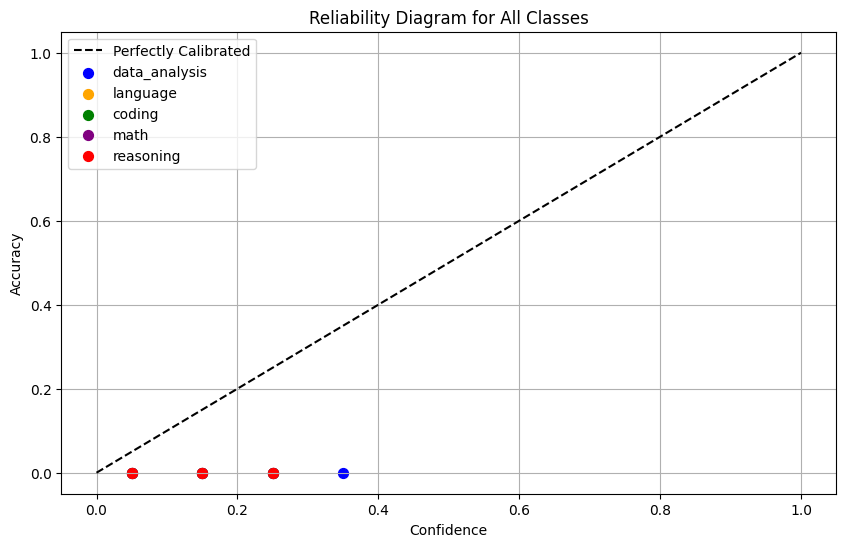

In [20]:
    # Example usage
pipeline = EvaluationPipeline(api_key="Your_api_key", judge_model_name="llama3-70b-8192", smaller_model_name=models[0]['name'])
pipeline.evaluate_folder("/kaggle/working/dev", dataset_type="livebench", num_questions=50) # if u control question
# pipeline.evaluate_folder("/kaggle/working/dev", dataset_type="livebench")